In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_labels = pd.read_csv("./data/train_labels.csv")
train_labels['id'] = train_labels['id'] + ".tif"
train_labels['label'] = train_labels['label'].astype("string")

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory="./data/train/",
    x_col="id",          
    y_col="label", 
    target_size=(96, 96), 
    batch_size=32, 
    class_mode='binary',
    subset="training"
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory="./data/train/",
    x_col="id",          
    y_col="label", 
    target_size=(96, 96), 
    batch_size=32, 
    class_mode='binary',
    subset="validation"
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('./data/', classes=['test'], target_size=(96, 96), shuffle=False, class_mode=None)


Found 165019 validated image filenames belonging to 2 classes.
Found 55006 validated image filenames belonging to 2 classes.
Found 57458 images belonging to 1 classes.


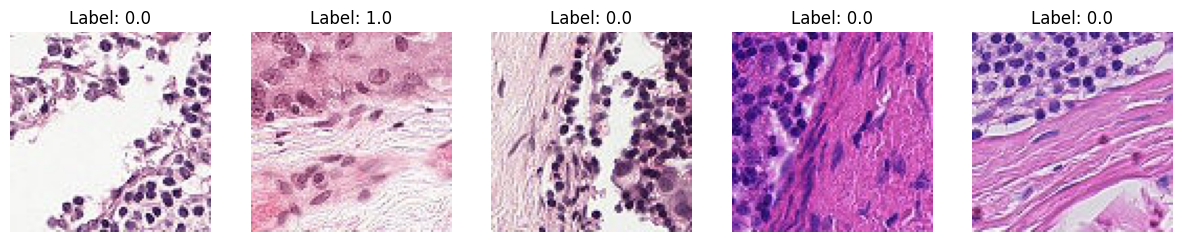

In [4]:
images, labels = next(train_generator)

fig, axes = plt.subplots(1, 5, figsize=(15, 15))
for i in range(5):
    axes[i].imshow(images[i])
    axes[i].axis("off")
    axes[i].set_title(f"Label: {labels[i]}")
    
plt.show()

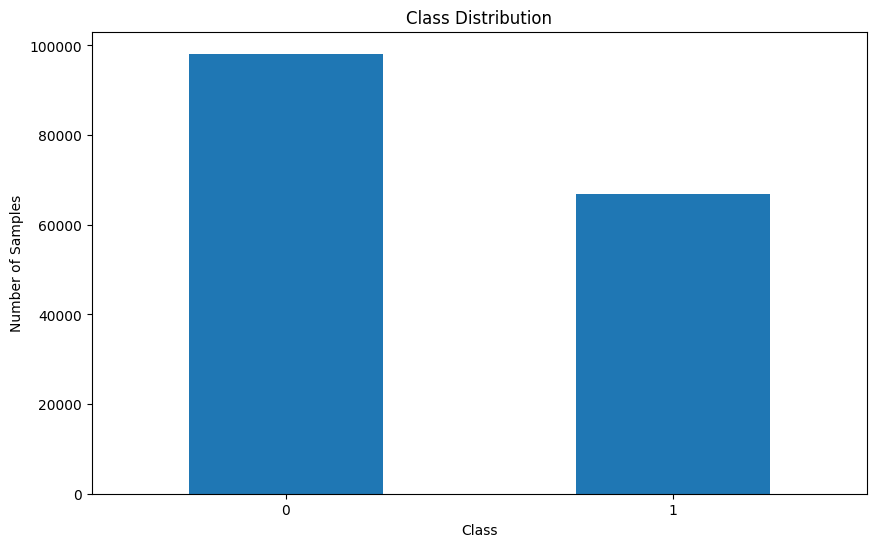

In [5]:
labels = pd.DataFrame(train_generator.labels, columns=["label"])
class_counts = labels["label"].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind="bar")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=0)
plt.show()

Given this is medical data, the distribution of classes is relatively even which is good for model training at it has plenty of examples to learn from.

The architecture of the model is dependent on the number on the depth of the network. For each additional level of depth, there will be double the number of layers as seen in the previous level, ensuring capture of details that may not be as obvious. The tunable paremeters for the model are the activation function, size of the max pooling window, the depth of the network, dropout rate, and number of base layers. For each level, there is a convolution layer and max pooling layer. At the end, the layer is flattened and another dense layer is added; this is also where the dropout occurs as to ensure there is no overfitting in the model. At the end, the sigmoid function is used as the final activation function.

In [6]:
from tensorflow.keras import layers, models

class image_class_model:

    def __init__(self, activation, maxPooling, depth, dropout, base_layers):
        self.activation = activation
        self.maxPooling = maxPooling
        self.depth = depth
        self.dropout = dropout
        self.base_layers = base_layers
        self.model = None
        self.history = None
    
    def create_model(self):
        self.model = models.Sequential()

        for i in range(self.depth):
            self.model.add(layers.Conv2D(self.base_layers * (2 ** i), (3, 3), activation = self.activation))
            self.model.add(layers.MaxPooling2D(self.maxPooling))
        
        self.model.add(layers.Flatten())
        self.model.add(layers.Dense(self.base_layers * (2 ** (self.depth - 1))))
        self.model.add(layers.Dropout(self.dropout))
        self.model.add(layers.Dense(1, activation="sigmoid"))
    
    def compile_model(self):
        self.model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

    def eval(self, train_generator, validation_generator):
        self.history = self.model.fit(train_generator, validation_data=validation_generator)
    
    def show_results(self):
        
        print("Activation: " + str(self.activation))
        print("Max Pooling Size: " + str(self.maxPooling))
        print("Depth: " + str(self.depth))
        print("Dropout: " + str(self.dropout))
        print("Base Layers: " + str(self.base_layers))

        print("ACCURACY: " + str(self.history.history['val_accuracy']))
    
    def get_accuracy(self):

        return self.history.history["val_accuracy"]


The first hyperparameter tuning performed involved trying different depths; at each level there is a doubling in the number of layers.

In [ ]:
acc = []

depth = [i for i in range(1, 5)]

bestModel = None
bestAcc = -1

for d in depth:
    model = image_class_model("relu", (2, 2), d, 0.5, 32)
    model.create_model()
    model.compile_model()
    model.eval(train_generator, validation_generator)
    model.show_results()
    accuracy = model.get_accuracy() 

    acc.append(accuracy[0])
    if accuracy[0] > bestAcc:
        bestModel = model
        bestAcc = accuracy[0]

5157/5157 ━━━━━━━━━━━━━━━━━━━━ 591s 114ms/step - accuracy: 0.7492 - loss: 0.6461 - val_accuracy: 0.8040 - val_loss: 0.4417
Activation: relu
Max Pooling Size: (2, 2)
Depth: 1
Dropout: 0.5
Base Layers: 32
ACCURACY: [0.8040213584899902]
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 1312s 254ms/step - accuracy: 0.7554 - loss: 0.5201 - val_accuracy: 0.8268 - val_loss: 0.4052
Activation: relu
Max Pooling Size: (2, 2)
Depth: 2
Dropout: 0.5
Base Layers: 32
ACCURACY: [0.8268188834190369]
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 556s 108ms/step - accuracy: 0.7808 - loss: 0.4760 - val_accuracy: 0.8524 - val_loss: 0.3454
Activation: relu
Max Pooling Size: (2, 2)
Depth: 3
Dropout: 0.5
Base Layers: 32
ACCURACY: [0.8524342775344849]
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 561s 109ms/step - accuracy: 0.7825 - loss: 0.4661 - val_accuracy: 0.8615 - val_loss: 0.3305
Activation: relu
Max Pooling Size: (2, 2)
Depth: 4
Dropout: 0.5
Base Layers: 32
ACCURACY: [0.861524224281311]


Text(0.5, 1.0, 'Validation Accuracy v. CNN Depth (Base Layers = 32)')

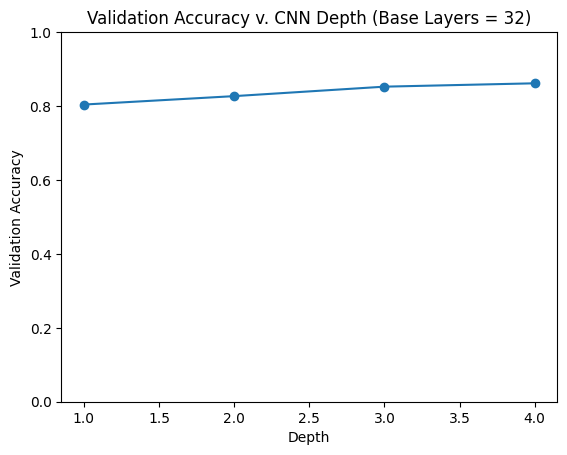

In [9]:
plt.scatter(depth, acc)
plt.plot(depth, acc)
plt.xlabel("Depth")
plt.ylabel("Validation Accuracy")
plt.ylim(0, 1)
plt.title("Validation Accuracy v. CNN Depth (Base Layers = 32)")

The next set of tuning was for the dropout rate to see if there could be some potential for reducing overfitting that impacts the model's accuracy.

In [13]:
acc = []

dropout = [0.1, 0.25, 0.5]

bestModel = None
bestAcc = -1

for d in dropout:
    model = image_class_model("relu", (2, 2), 4, d, 32)
    model.create_model()
    model.compile_model()
    model.eval(train_generator, validation_generator)
    model.show_results()
    accuracy = model.get_accuracy() 

    acc.append(accuracy[0])
    if accuracy[0] > bestAcc:
        bestModel = model
        bestAcc = accuracy[0]

C:\Users\James\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5157/5157 ━━━━━━━━━━━━━━━━━━━━ 1048s 203ms/step - accuracy: 0.7822 - loss: 0.4691 - val_accuracy: 0.8494 - val_loss: 0.3495
Activation: relu
Max Pooling Size: (2, 2)
Depth: 4
Dropout: 0.1
Base Layers: 32
ACCURACY: [0.8493618965148926]
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 938s 181ms/step - accuracy: 0.7840 - loss: 0.4653 - val_accuracy: 0.8728 - val_loss: 0.3013
Activation: relu
Max Pooling Size: (2, 2)
Depth: 4
Dropout: 0.25
Base Layers: 32
ACCURACY: [0.87277752161026]
5157/5157 ━━━━━━━━━━━━━━━━━━━━ 918s 178ms/step - accuracy: 0.7753 - loss: 0.4766 - val_accuracy: 0.8440 - val_loss: 0.3539
Activation: relu
Max Pooling Size: (2, 2)
Depth: 4
Dropout: 0.5
Base Layers: 32
ACCURACY: [0.8440170288085938]


Text(0.5, 1.0, 'Validation Accuracy v. Dropout (Base Layers = 32)')

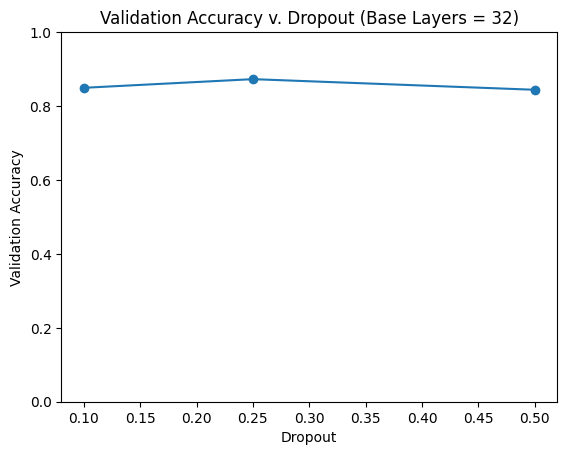

In [16]:
plt.scatter(dropout, acc)
plt.plot(dropout, acc)
plt.xlabel("Dropout")
plt.ylabel("Validation Accuracy")
plt.ylim(0, 1)
plt.title("Validation Accuracy v. Dropout (Base Layers = 32)")

In [15]:
predictions = bestModel.model.predict(test_generator)
predicted_labels = (predictions > 0.5).astype(int).flatten()

fileNames = test_generator.filenames
ids = [file.split("\\")[1].split(".")[0] for file in fileNames]
df = pd.DataFrame({'id': ids, 'label': predicted_labels})
output_csv_path = 'predictions.csv'
df.to_csv(output_csv_path, index=False)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 258s 144ms/step


In the end, having a deeper network did improve results, and some dropout (0.25) was needed to get the best results. There is a tradeoff that needs to be understood; while the model may be stronger with a more in-depth architecture, this also incurs additional resources in the form of compute. Depending on the scenario, it may be beneficial to be more lenient in one area than another.